The first goal of this is to show how implementing high-pass filters on the data may improve the final result of our process.

The second goal is to demonstrate a method of calculating average frequencies and amplitudes for .wav files.

I will be running analysis on two .wav files, the first of which is unmodified. The second (bottom) file has recieved a high pass filter at 5000 Hz and a -6 dB rolloff, after which it also recieved a heavy leveler with a -20 dB threshold in order to normalize the amplitudes; these effects are packeged in with Audacity, which I used to produce the image below. It is easy to see the difference it has made with the reduction of noise between and around the bird calls.

![title](Images/highpass.jpg)

Next, I will run a noise reduction on both the original and filtered files using the noisereduce library. The first reduction is the original, and the second one is the filtered .wav file.

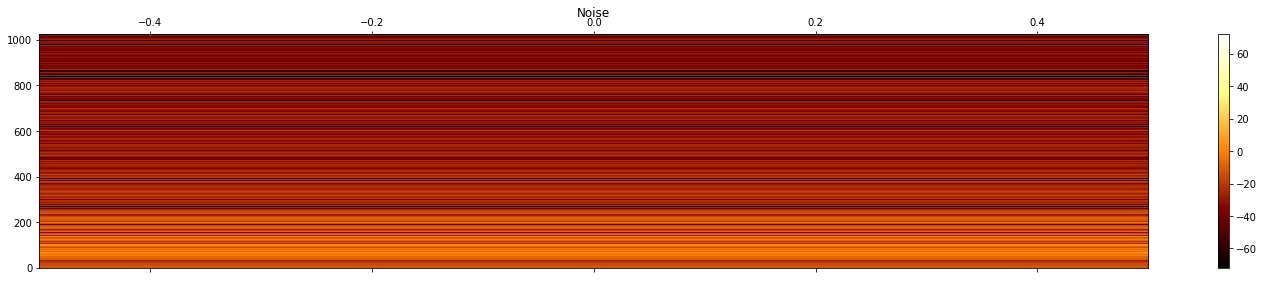

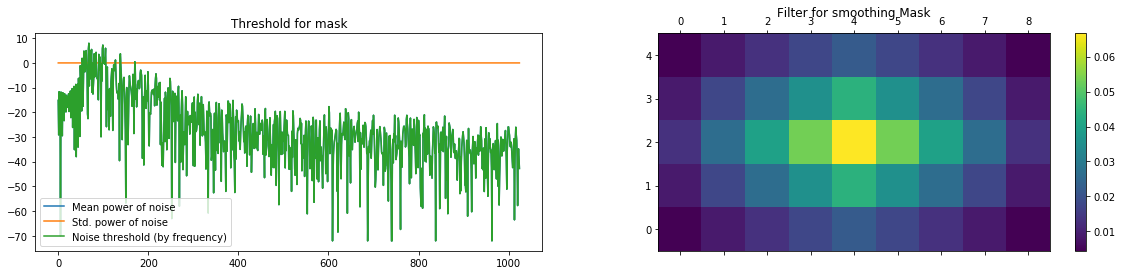

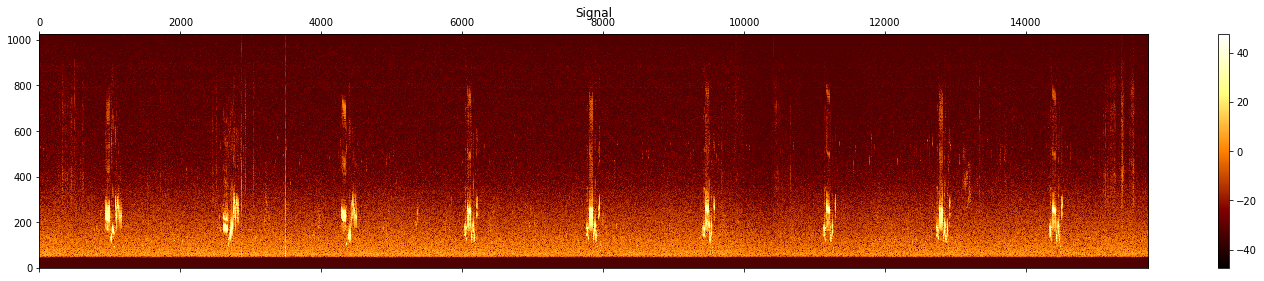

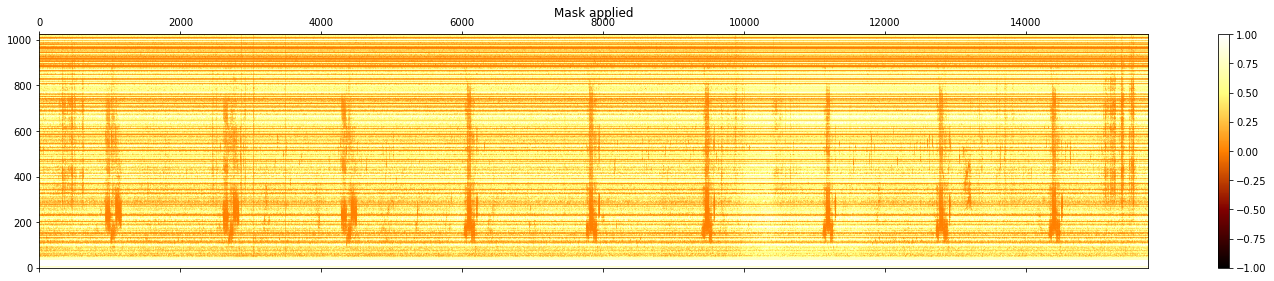

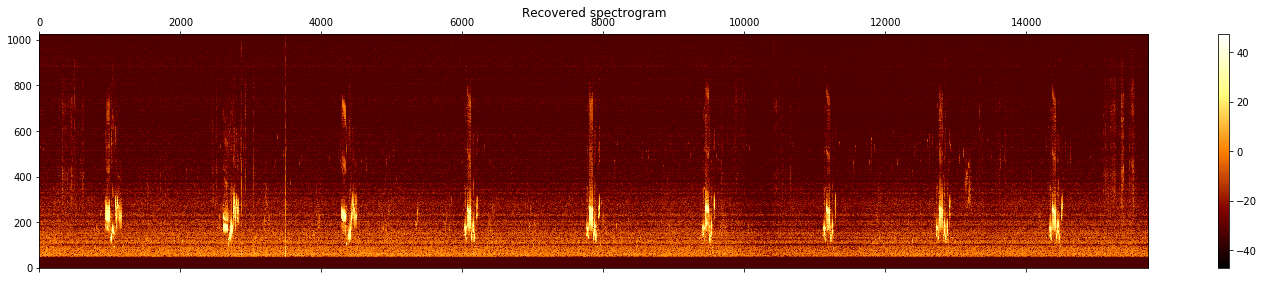

In [4]:
import noisereduce as nr
import scipy as sp
import wavefile as wv

# use wavefile module to convert wav from int to float
filename = 	"SongFiles/LISP,060603,0748,37.74615N,107.68739W,6.wav"
w = wv.load(filename)
data = w[1][0]

# load data (perhaps unnecessary as done previously)
# (deprecated) rate, data = sp.io.wavfile.read(filename)

# select section of data that is noise
noisy_part = data[1500:2000]

# perform noise reduction
reduced_noise = nr.reduce_noise(audio_clip=data, noise_clip=noisy_part, n_std_thresh=1.5, prop_decrease=1, verbose=True)

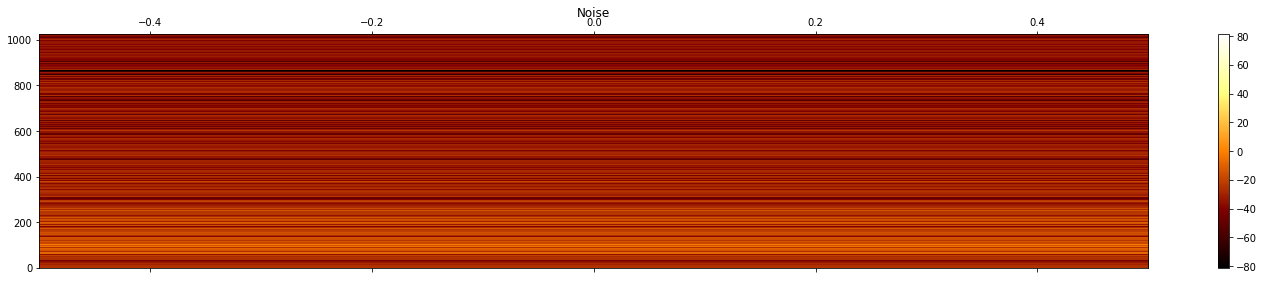

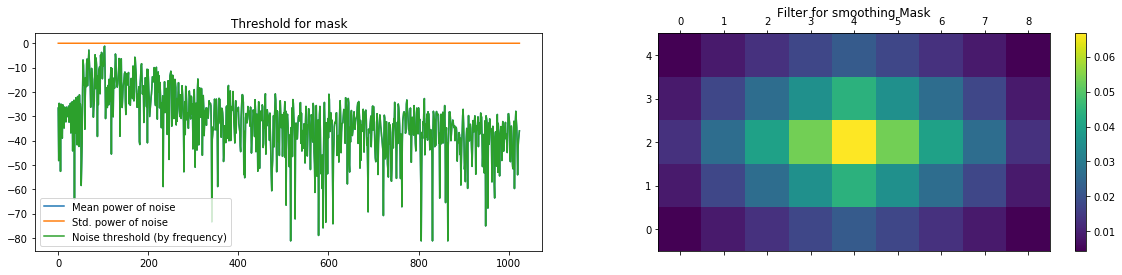

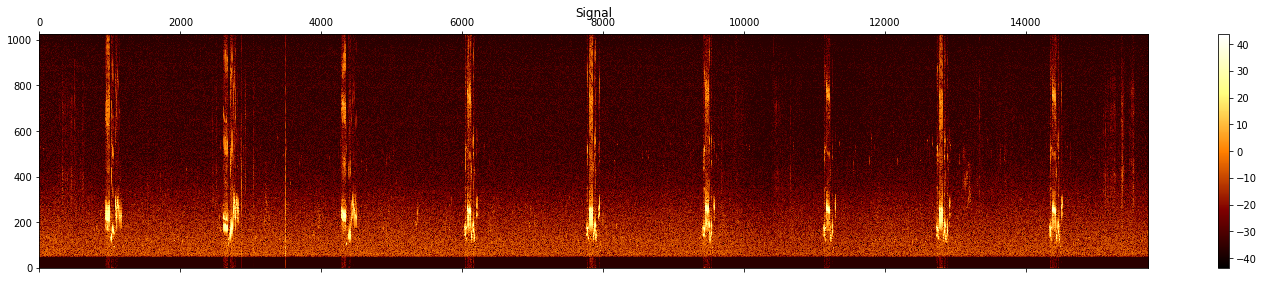

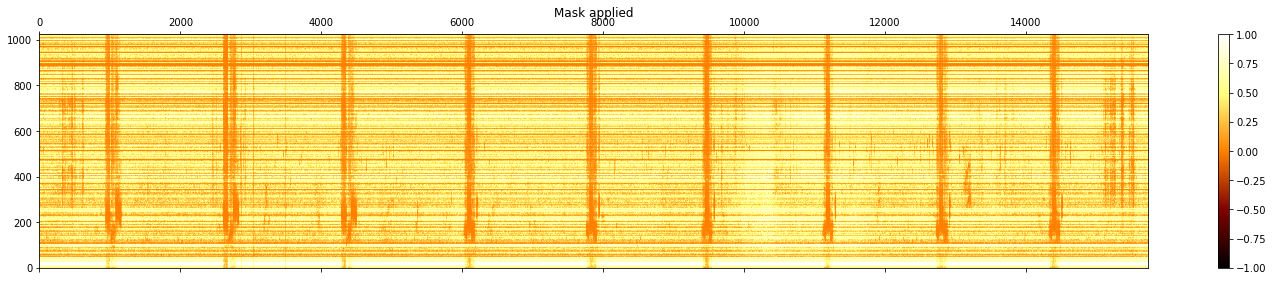

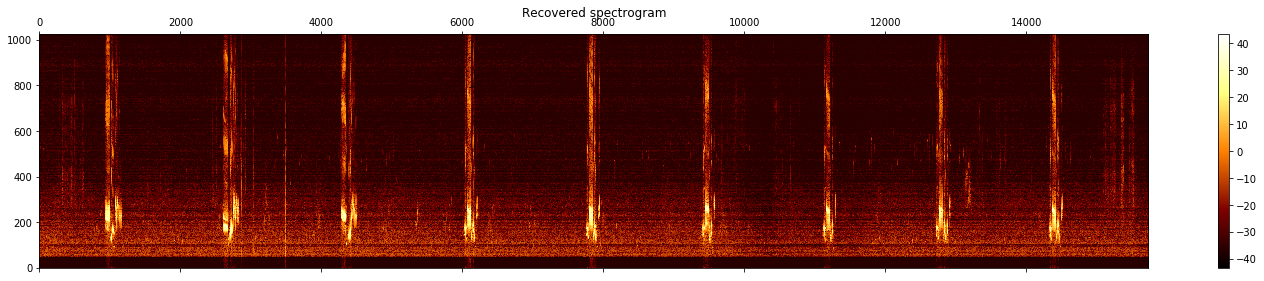

In [2]:
import noisereduce as nr
import scipy as sp
import wavefile as wv

# use wavefile module to convert wav from int to float
filename = 	"SongFiles/0748Reduced.wav"
w = wv.load(filename)
data = w[1][0]

# load data (perhaps unnecessary as done previously)
# (deprecated) rate, data = sp.io.wavfile.read(filename)

# select section of data that is noise
noisy_part = data[1500:2000]

# perform noise reduction
reduced_noise = nr.reduce_noise(audio_clip=data, noise_clip=noisy_part, n_std_thresh=1.5, prop_decrease=1, verbose=True)

Comparing the two recovered spectrograms, it is evident that the high pass filtered file (bottom image) has a slightly better noise reduction and more prominent peaks than the original file (top image). The larger peaks may be a good or bad thing depending on what data works better for our client.

![title](Images/spectro1.png)
![title](Images/spectro2.png)

I haven't figured out how to make use of the noise reduced data above, so I will be running the next bits of code just with the unreduced original and high pass filtered files. The next step is to process the 9 bird call peaks in each .wav file and to return them in a series of 9 isolated chunk files. Pydub does a good job at this, so I will be using it.

In [12]:
from pydub import AudioSegment
from pydub.silence import split_on_silence
from pydub.playback import play

# AudioSegment.from_wav does not work with 1411kbps wav files -> something to do with ffmpeg
# It does work with 705kbps**
# loading new audio into pydub
rnbirds = AudioSegment.from_wav("SongFiles/LISP,060603,0748,37.74615N,107.68739W,6.wav")

# testing
print(rnbirds.dBFS)

# split into chunks using pydub
chunks = split_on_silence(
    # Use the loaded audio.
    rnbirds, 
    # Consider a chunk silent if it's less than the silence threshold
    silence_thresh = -30
)

for i, chunk in enumerate(chunks):
    chunk.export("ChunkFiles/chunk{0}.wav".format(i), format="wav")

-24.615873043424045


In [11]:
from pydub import AudioSegment
from pydub.silence import split_on_silence
from pydub.playback import play

# AudioSegment.from_wav does not work with 1411kbps wav files -> something to do with ffmpeg
# It does work with 705kbps**
# loading new audio into pydub
rnbirds = AudioSegment.from_wav("SongFiles/0748Reduced.wav")

# testing
print(rnbirds.dBFS)

# split into chunks using pydub
chunks = split_on_silence(
    # Use the loaded audio.
    rnbirds, 
    # Consider a chunk silent if it's less than the silence threshold
    silence_thresh = -30
)

for i, chunk in enumerate(chunks):
    chunk.export("ChunkFiles/chunk{0}.wav".format(i + 9), format="wav")

-27.990135160413253


Lastly, I will be using the following code to calculate the average frequency in Hz and average amplitude in dB of the first bird call (sound chunk) in both the original and filtered files using librosa for file loading and numpy for fourier transforms that allow us to obtain frequency values.

In [13]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def avg_amplitude(y: np.ndarray) -> float:
    """
    amplitude is converted to dB using amplitude_to_db
    if needed, relative amplitudes can be used to calculate the average instead using y instead of z
    """
    
    ampSum = 0
    z = librosa.core.amplitude_to_db(S=y)
    
    for i in range(len(z)):
        ampSum += abs(z[i])
    
    avg = ampSum/len(z)
    return avg

def avg_frequency(y: np.ndarray, fs: int) -> float:
    """
    Compute mean frequency

    :param y: 1-d signal
    :param fs: sampling frequency [Hz]
    :return: mean frequency
    """
    spec = np.abs(np.fft.rfft(y))
    freq = np.fft.rfftfreq(len(y), d=1/fs)    
    amp = spec / spec.sum()
    mean = (freq * amp).sum()
    return mean

# load chunk
filename = 	"ChunkFiles/chunk0.wav"

# load audio as waveform, sampling rate as sr
y, sr = librosa.load(filename, None, True, 0, None)
                     
print("Avg Freq: " + str(avg_frequency(y, sr)) + " Hz")
print("Avg Amp: " + str(avg_amplitude(y)) + " dB")

Avg Freq: 4354.046473775418 Hz
Avg Amp: 25.977629734045934 dB


In [14]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def avg_amplitude(y: np.ndarray) -> float:
    """
    amplitude is converted to dB using amplitude_to_db
    if needed, relative amplitudes can be used to calculate the average instead using y instead of z
    """
    
    ampSum = 0
    z = librosa.core.amplitude_to_db(S=y)
    
    for i in range(len(z)):
        ampSum += abs(z[i])
    
    avg = ampSum/len(z)
    return avg

def avg_frequency(y: np.ndarray, fs: int) -> float:
    """
    Compute mean frequency

    :param y: 1-d signal
    :param fs: sampling frequency [Hz]
    :return: mean frequency
    """
    spec = np.abs(np.fft.rfft(y))
    freq = np.fft.rfftfreq(len(y), d=1/fs)    
    amp = spec / spec.sum()
    mean = (freq * amp).sum()
    return mean

# load chunk
filename = 	"ChunkFiles/chunk9.wav"

# load audio as waveform, sampling rate as sr
y, sr = librosa.load(filename, None, True, 0, None)
                     
print("Avg Freq: " + str(avg_frequency(y, sr)) + " Hz")
print("Avg Amp: " + str(avg_amplitude(y)) + " dB")

Avg Freq: 5428.607084270861 Hz
Avg Amp: 30.33783819424071 dB


The average frequency of the first chunk in the original file is 4354 Hz, while the average amplitude is about 26 dB. As for the high pass filtered file, the average frequency of the first chunk is 5429 Hz, while the average amplitude is 30.3 dB. I am currently not quite sure of the significance of these values - they obviously differ because of the filter and leveler applied to the second one; however, if we apply the same filters to all files, they can still be measured relatively. We will just have to see what final data works better for Dr. Sockman. It is also possible to display the average amplitude as relative percentages rather than literal decibal values if needed.

The hope here is that using these snippets of code, we can effectively calculate 18 average frequencies and amplitudes per every single bird call (chunk) by splitting the chunk up into 18 smaller chunks with equal time intervals and then running the code on each of them. If noise causes future problems, we could then also consider running high pass filters and normalizers on the data before processing it to see if it produced better values for Dr. Sockman. Below is a snippet of potential code I found that is capable of applying high pass filters, albeit with a very different result than Audacity's.

In [17]:
from scipy.io import wavfile
from scipy import signal
import numpy as np

sr, x = wavfile.read('SongFiles/LISP,060603,0748,37.74615N,107.68739W,6.wav') # 16-bit mono 44.1 khz

b = signal.firwin(101, cutoff=4000, fs=sr, pass_zero=False) # Cutoff = cutoff frequency in Hz

x = signal.lfilter(b, [1.0], x)

wavfile.write('SongFiles/test.wav', sr, x.astype(np.int16))

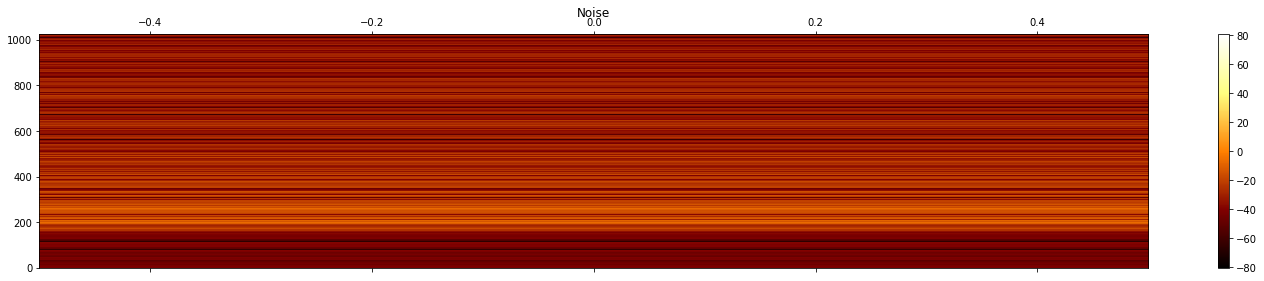

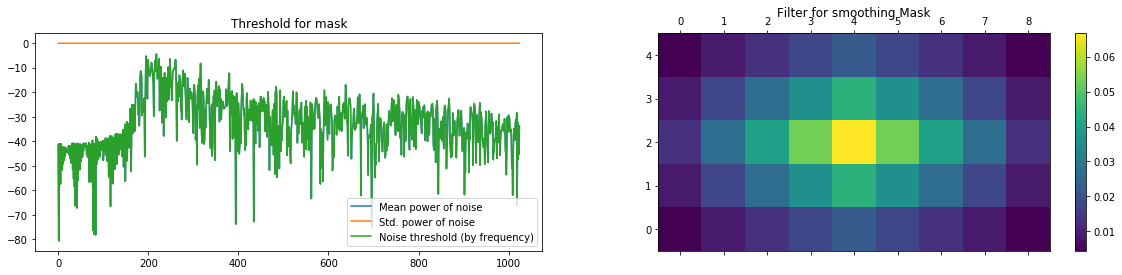

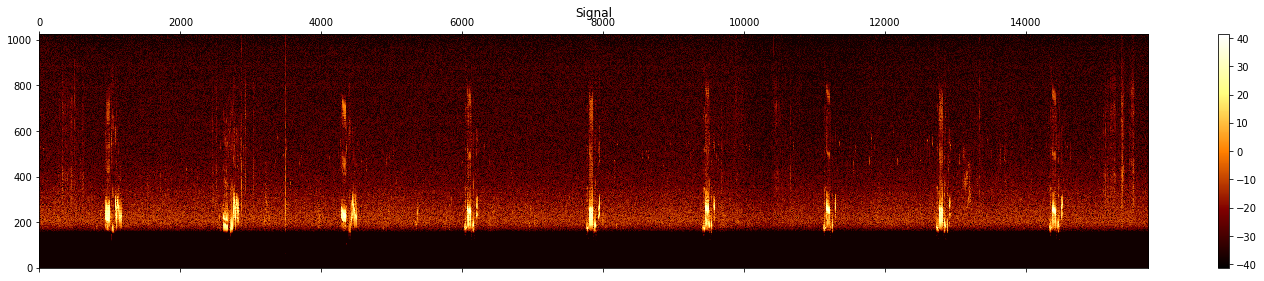

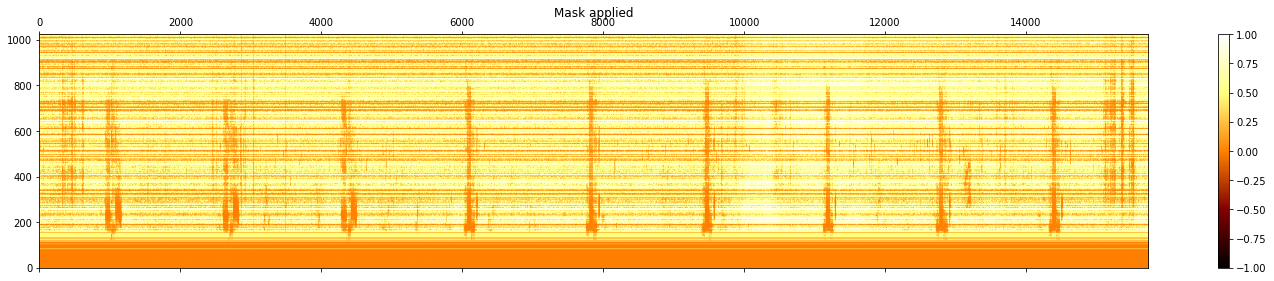

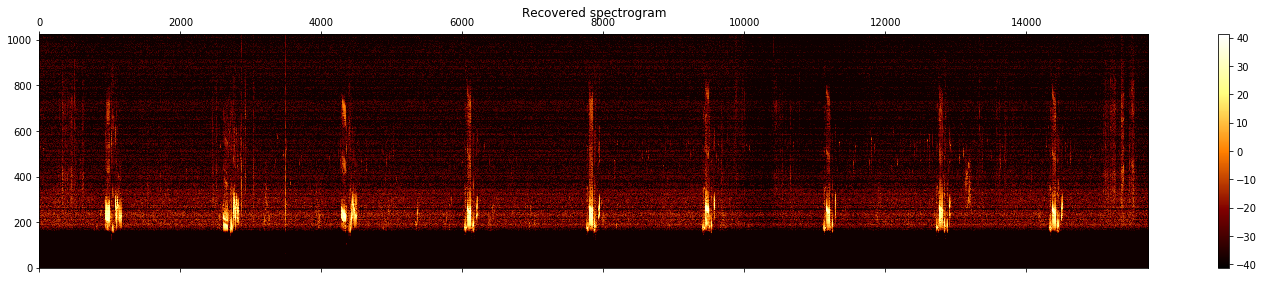

In [18]:
import noisereduce as nr
import scipy as sp
import wavefile as wv

# use wavefile module to convert wav from int to float
filename = 	"SongFiles/test.wav"
w = wv.load(filename)
data = w[1][0]

# load data (perhaps unnecessary as done previously)
# (deprecated) rate, data = sp.io.wavfile.read(filename)

# select section of data that is noise
noisy_part = data[1500:2000]

# perform noise reduction
reduced_noise = nr.reduce_noise(audio_clip=data, noise_clip=noisy_part, n_std_thresh=1.5, prop_decrease=1, verbose=True)

Compare the above scipy high pass filtered data with original, and then the Audacity filtered data:
![title](Images/spectro1.png)
![title](Images/spectro2.png)